In [1]:
import tensorflow as tf
from data import ClicData
import cv2
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

## Load models from trained path

In [2]:
from net import load_model, ImageCodec
path = 'logs/scaled_3'
input_size = [1, 180, 180, 3]

Cr = load_model('cr', path, input_size)
Re = load_model('re', path, input_size)
Co = ImageCodec()

In [3]:

ds = ClicData().get_val()
data, = ds.take(1)

In [4]:
out = Cr(data)

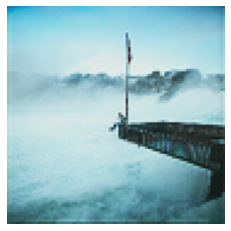

(90, 90, 3)


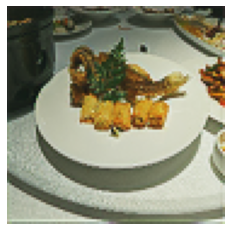

(90, 90, 3)


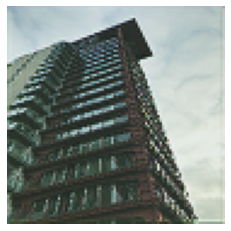

(90, 90, 3)


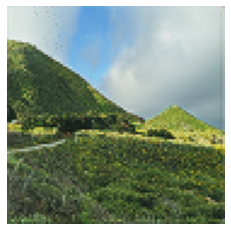

(90, 90, 3)


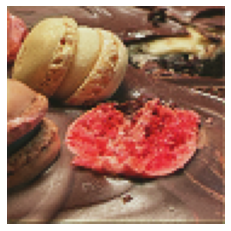

(90, 90, 3)


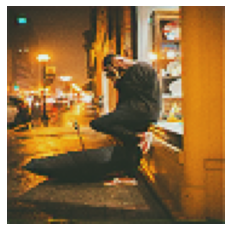

(90, 90, 3)


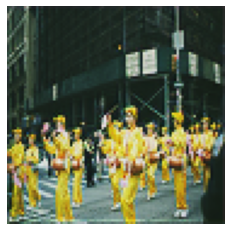

(90, 90, 3)


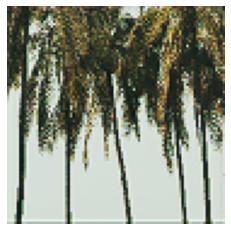

(90, 90, 3)


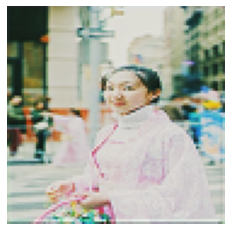

(90, 90, 3)


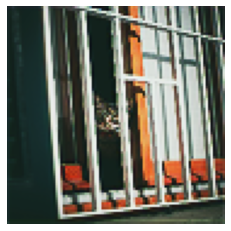

(90, 90, 3)


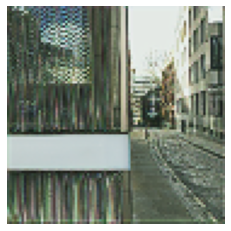

(90, 90, 3)


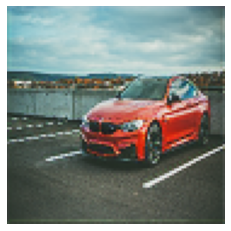

(90, 90, 3)


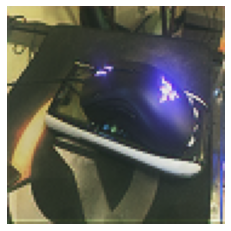

(90, 90, 3)


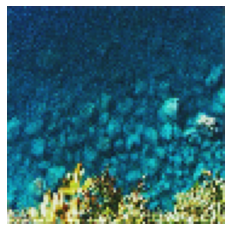

(90, 90, 3)


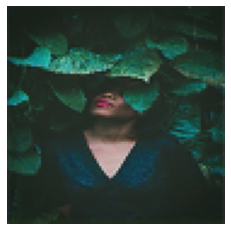

(90, 90, 3)


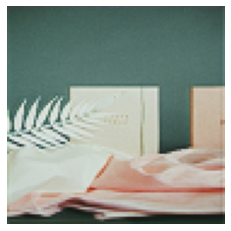

(90, 90, 3)


In [10]:
for i in range(16):
    im = out[i].numpy()
    plt.axis('off')
    plt.imshow(im)
    plt.show()
    print(im.shape)

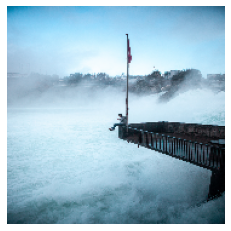

(180, 180, 3)


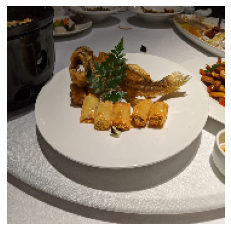

(180, 180, 3)


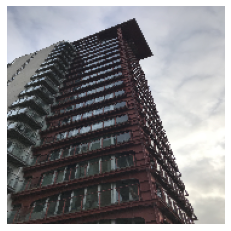

(180, 180, 3)


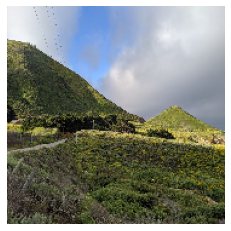

(180, 180, 3)


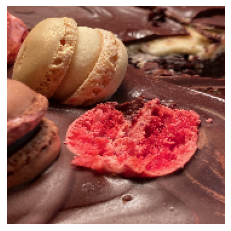

(180, 180, 3)


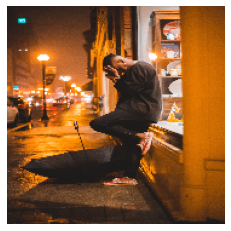

(180, 180, 3)


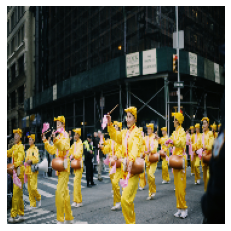

(180, 180, 3)


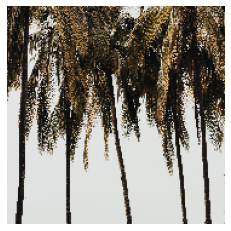

(180, 180, 3)


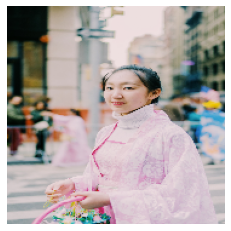

(180, 180, 3)


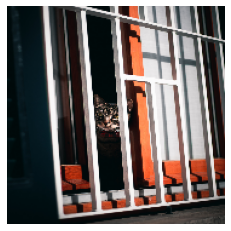

(180, 180, 3)


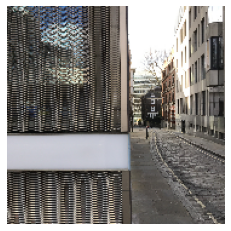

(180, 180, 3)


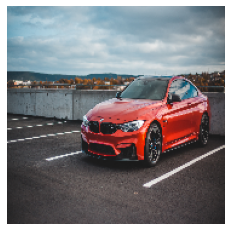

(180, 180, 3)


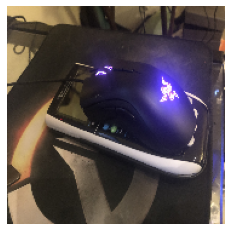

(180, 180, 3)


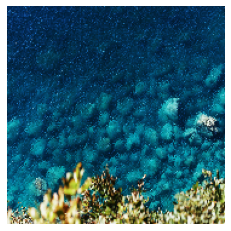

(180, 180, 3)


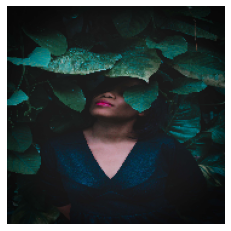

(180, 180, 3)


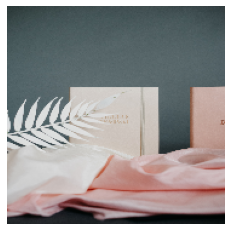

(180, 180, 3)


In [9]:
for i in range(16):
    im = data[i].numpy()
    plt.axis('off')
    plt.imshow(im)
    plt.show()
    print(im.shape)

In [32]:

# Take validation batch and compute reconstruction with compressed sizes as well
# as traditional JPEG compression and sizes

ds = ClicData().get_val()
data, = ds.take(1)


compact, ml_sizes = Co.with_sizes( Cr(data) )
ml_images = Re(compact)
ml_images = tf.minimum(tf.maximum(ml_images, 0), 1.0)


jpeg_codec = ImageCodec(quality=60)

jpeg_images, jpeg_sizes = jpeg_codec.with_sizes(data)


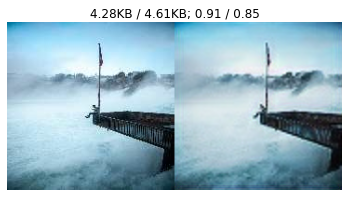

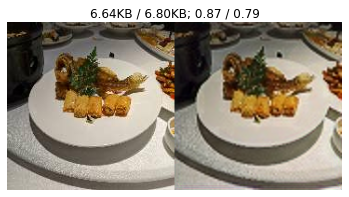

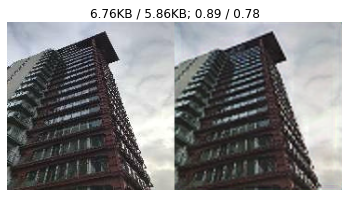

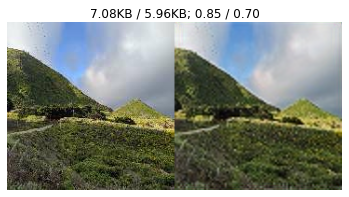

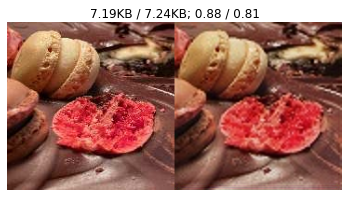

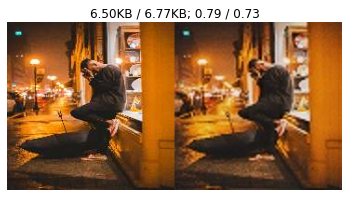

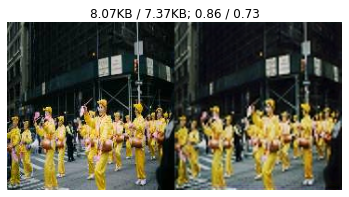

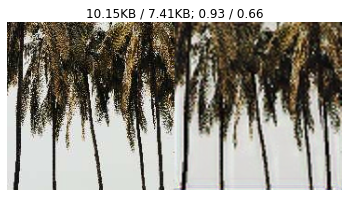

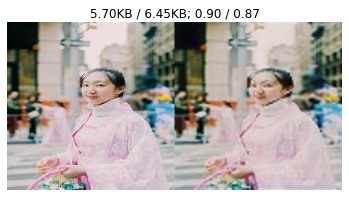

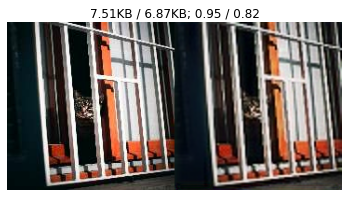

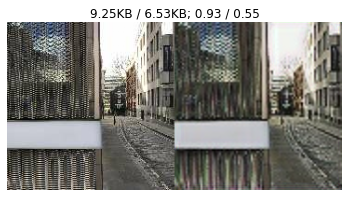

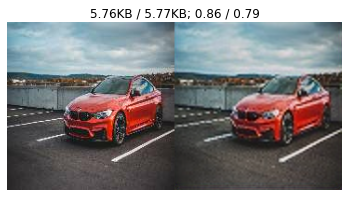

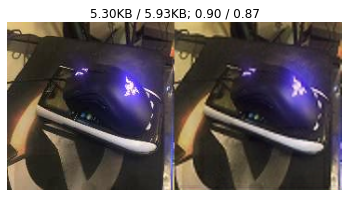

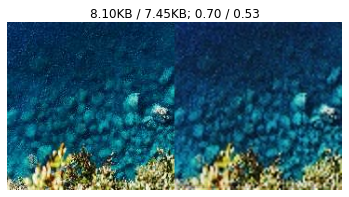

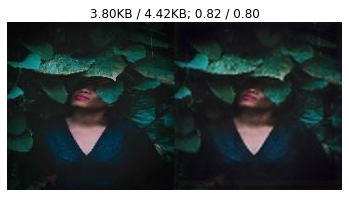

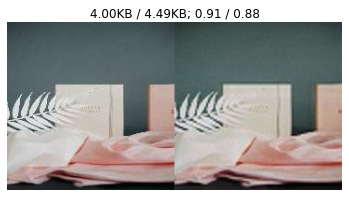

In [29]:


# Stack the images for comparison and the sizes
images = tf.concat([jpeg_images, ml_images], axis=2).numpy()
sizes = tf.stack([jpeg_sizes, ml_sizes], axis=1).numpy()/1024

# Calculate the SSIM vs the ground truth
ssims_jpeg = tf.image.ssim(data, jpeg_images, max_val=1.0)
ssims_ml = tf.image.ssim(data, ml_images, max_val=1.0)

for i in range(data.shape[0]):
    plt.axis('off')
    j, m = sizes[i]
    plt.title(f'{j:.{2}f}KB / {m:.{2}f}KB; {ssims_jpeg[i]:.{2}f} / {ssims_ml[i]:.{2}f}')
    plt.imshow(images[i])
    plt.show()



## Run evaluation loop for each example in the validation set

In [2]:
from eval import Evaluator
from net import ImageCodec

config = {
                'epochs'      : 10,
                'lr_re'       : 1e-3,
                'lr_cr'       : 1e-3,
                'batch_size'  : 16,
                'no_log'      : True,
                'logs'        : 'logs',
                'resume_path' : 'logs/scaled_3'
}


e = Evaluator(config)

out = e.get_all()


  0%|          | 0/416 [00:00<?, ?it/s]

[RESUME TRAINING]


100%|██████████| 416/416 [00:16<00:00, 25.99it/s]


In [7]:

df = out['image_metrics'].iloc[:10]

ssims = df['ssim']
top_inds = df.index

examples = list(zip(top_inds, ssims))


codec = ImageCodec(quality=50)

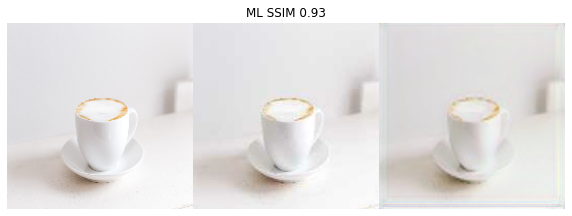

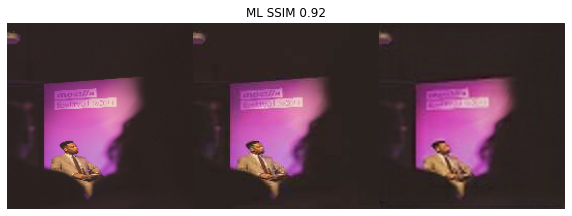

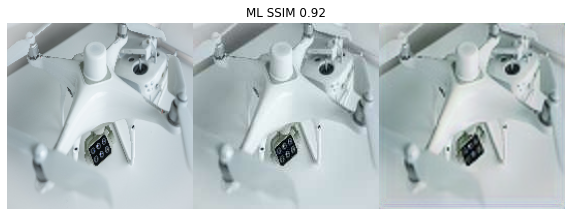

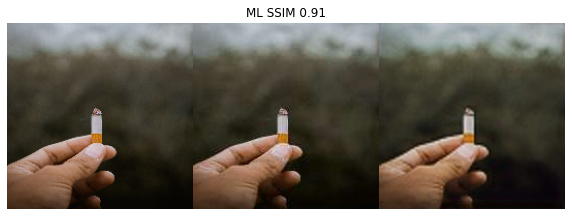

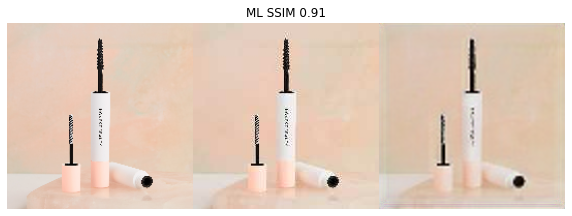

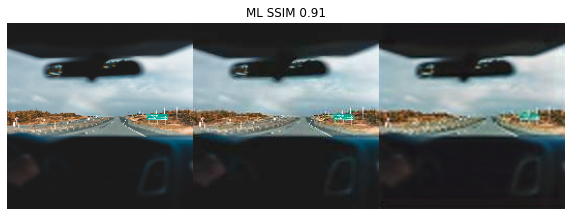

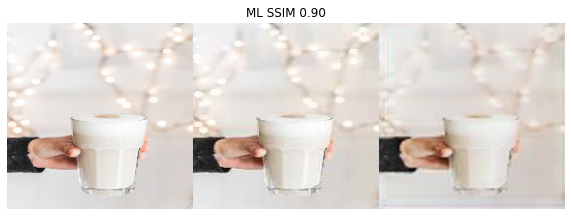

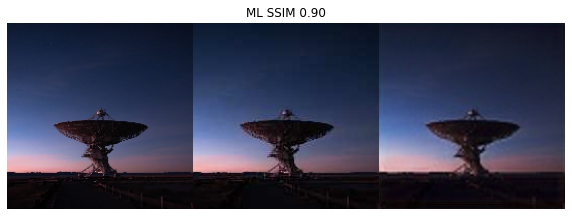

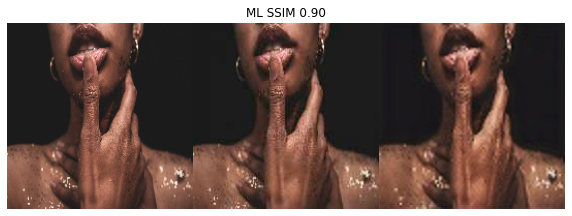

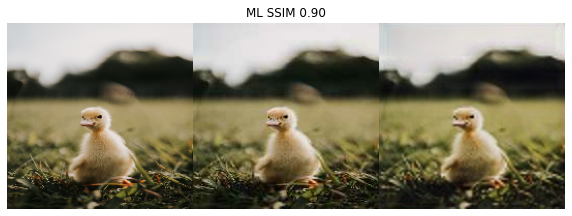

In [8]:

import matplotlib.pyplot as plt

for ind, ssim in examples:
    #j, m = sizes[i]
    
    fig, ax = plt.subplots(figsize=(10,20))
    
    original = out['image_map'][ind]['original']
    output = out['image_map'][ind]['output']
    image = np.concatenate([original, codec(original[None]).numpy()[0], output], axis=1)
    
    
    ax.set_title(f'ML SSIM {ssim:.{2}f}')
    ax.imshow(image)
    plt.axis('off')
    
    plt.show()